# Ensemble learning

Ensemble learning is a machine learning technique that combines predictions from multiple models (also known as 'base learners') to improve the overall performance, accuracy and robustness. The idea is that by aggregating the strengths of different models, the ensemble can outperform any individual model.

There are three main types of ensemble methods:


1.   **Bagging**: trains models on different subsets of the data, reducing variance. An example of bagging can be Random Forest.
2.   **Boosting**: reduces bias by sequentially training models, where each model focuses on correcting the errors of its predecessor. An example can be Boosting.
3. **Stacking**: it uses a 'meta model' to learn the best way to blend predictions from multiple models. An example is using logistic regression to combine oredictions from decision trees and SVMs.

In this way, bagging works with parallel models, boosting works with sequential models, and stacking combines predictions from multiple models by using a meta-model to learn the best way to integrate their outputs

The structure of these methods can be seen in the picture below, taken from [Spot Intelligence](https://spotintelligence.com/2023/08/09/ensemble-learning/)

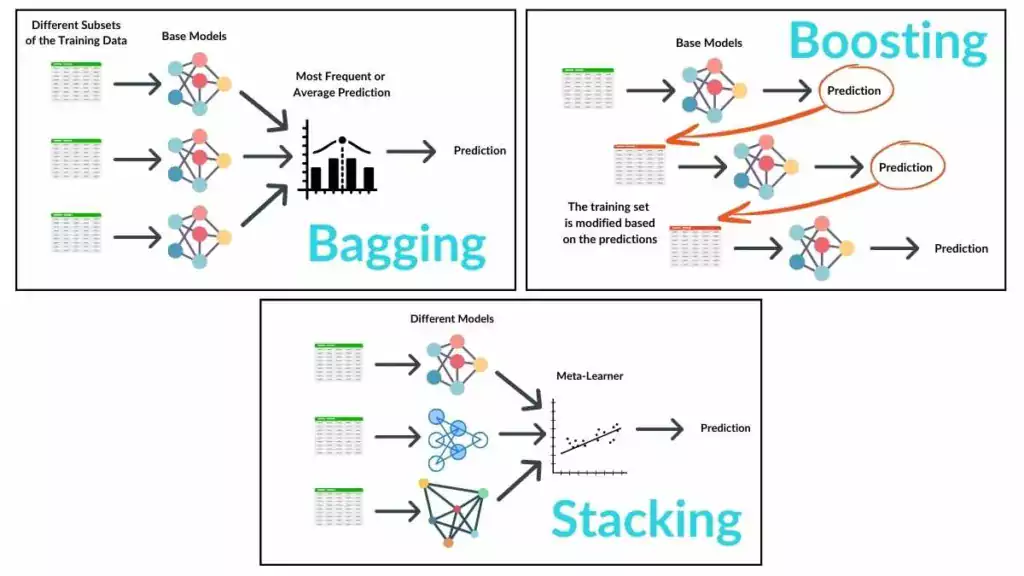


The goal of this project is to use ensamble learning to predict employees' satisfaction levels based on different factors. For this purpose, we will use different classifiers from sklearn and then combine them with different ensemble models.

**Dataset:** Employee Satisfaction Survey Data from Kaggle

In [3]:
# First, we import useful libraries for the project
import pandas as pd
import zipfile
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier

In [1]:
!pip install kaggle

In [2]:
!kaggle datasets download redpen12/employees-satisfaction-analysis


Dataset URL: https://www.kaggle.com/datasets/redpen12/employees-satisfaction-analysis
License(s): apache-2.0
100% 140k/140k [00:00<00:00, 654kB/s]
100% 140k/140k [00:00<00:00, 652kB/s]


In [4]:
with zipfile.ZipFile("employees-satisfaction-analysis.zip", "r") as zip_ref:
    zip_ref.extractall()



In [5]:
data = pd.read_csv("Employee Attrition.csv")
print(data)


        Emp ID  satisfaction_level  last_evaluation  number_project  \
0          1.0                0.38             0.53             2.0   
1          2.0                0.80             0.86             5.0   
2          3.0                0.11             0.88             7.0   
3          4.0                0.72             0.87             5.0   
4          5.0                0.37             0.52             2.0   
...        ...                 ...              ...             ...   
15782  14995.0                0.40             0.57             2.0   
15783  14996.0                0.37             0.48             2.0   
15784  14997.0                0.37             0.53             2.0   
15785  14998.0                0.11             0.96             6.0   
15786  14999.0                0.37             0.52             2.0   

       average_montly_hours  time_spend_company  Work_accident  \
0                     157.0                 3.0            0.0   
1              

In [6]:
# We see the column names
data.columns.unique()

Index(['Emp ID', 'satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident',
       'promotion_last_5years', 'dept', 'salary'],
      dtype='object')

**Preliminary visual analysis**
The idea of this preliminary visual analysis is to graphically explore relationships between variables to determine possible features for the model and their relationships between one another.

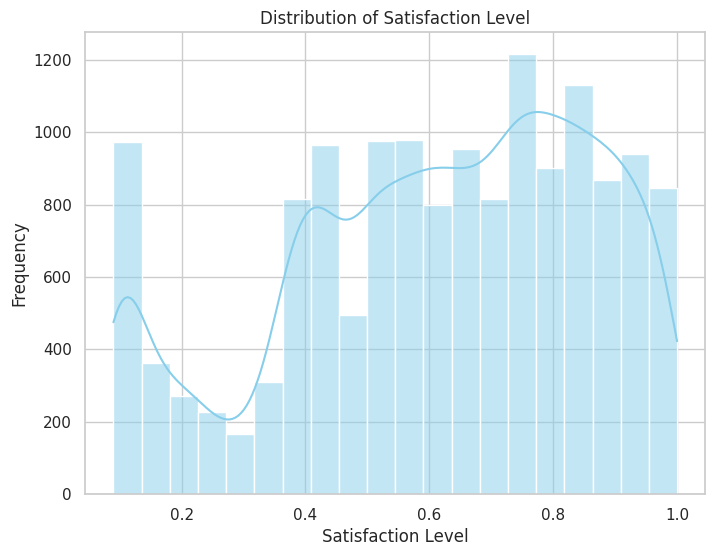

In [7]:
sns.set_theme(style="whitegrid")

# We plot the distribution of satisfaction level to see how the sample distribution is
plt.figure(figsize=(8, 6))
sns.histplot(data['satisfaction_level'], kde=True, bins=20, color='skyblue')
plt.title("Distribution of Satisfaction Level")
plt.xlabel("Satisfaction Level")
plt.ylabel("Frequency")
plt.show()





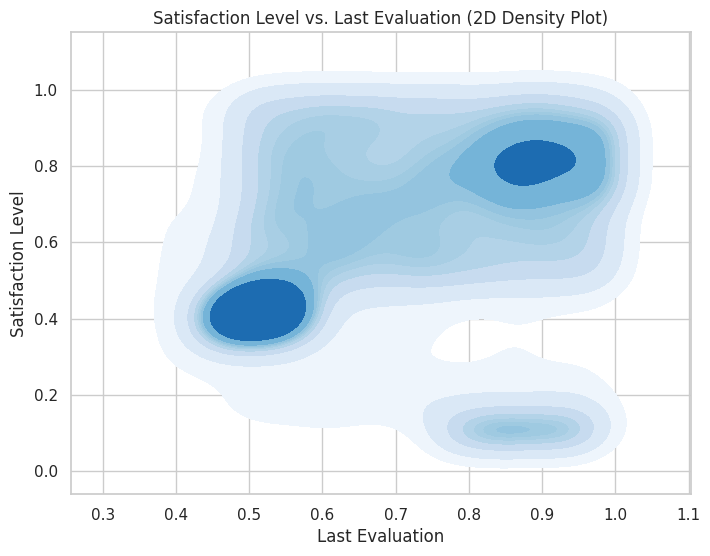

In [15]:
# We study the relation between the last evaluation and the satisfaction level through a density plot
plt.figure(figsize=(8, 6))
sns.kdeplot(data=data, x='last_evaluation', y='satisfaction_level', cmap='Blues', fill=True)
plt.xlabel("Last Evaluation")
plt.ylabel("Satisfaction Level")
plt.title("Satisfaction Level vs. Last Evaluation (2D Density Plot)")
plt.show()










<ipython-input-16-23a967b60310>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='number_project', y='satisfaction_level', palette='viridis')


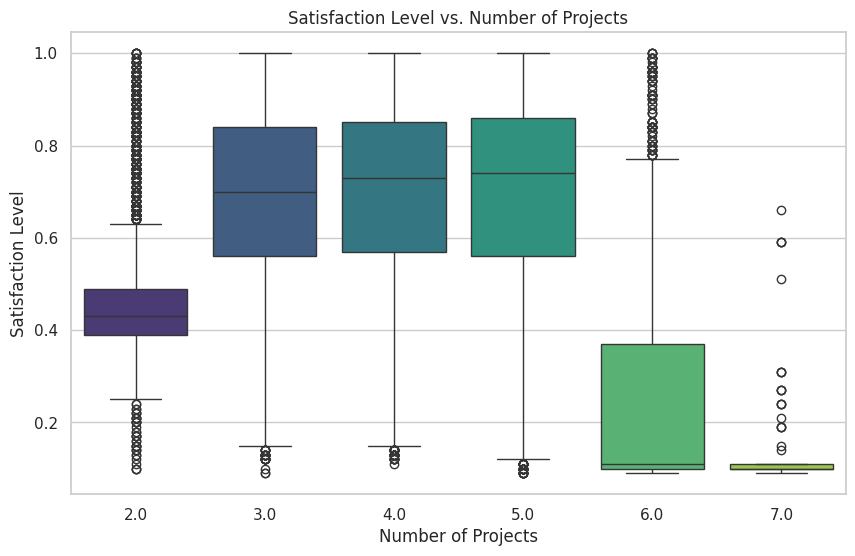

In [16]:
# We see if there is a relation between number of projects and satisfaction level. One would think that the most satisfied employees are the ones that have a reasonable nmb of projects (not too many or too less)
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='number_project', y='satisfaction_level', palette='viridis')
plt.title("Satisfaction Level vs. Number of Projects")
plt.xlabel("Number of Projects")
plt.ylabel("Satisfaction Level")
plt.show()



<ipython-input-17-a7a2eef01e33>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='dept', y='satisfaction_level', palette='Set2')


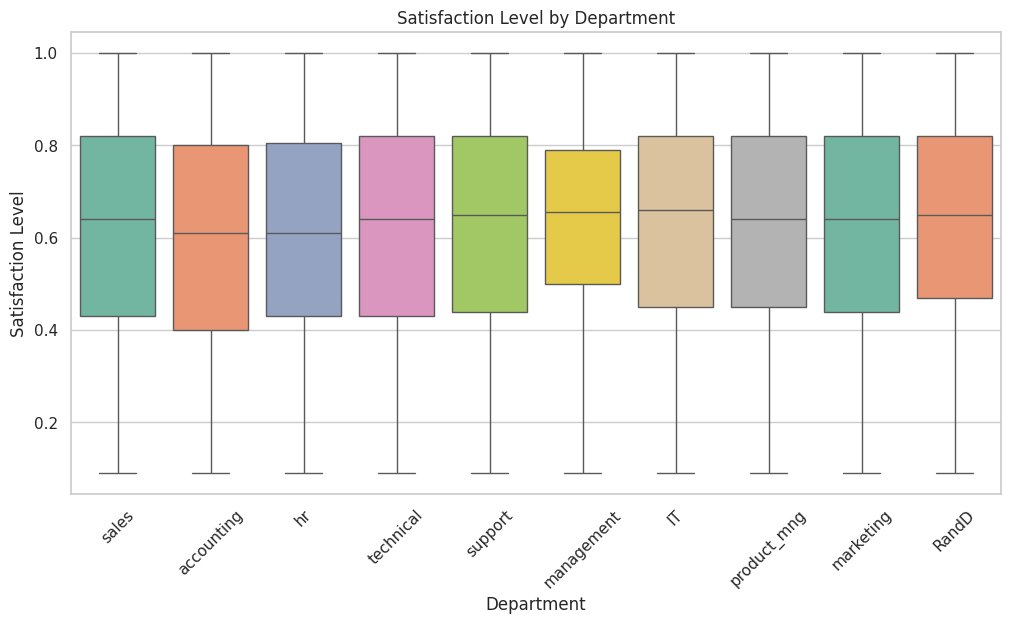

In [17]:
# We see if there is a relation between the department and the satisfaction level.
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='dept', y='satisfaction_level', palette='Set2')
plt.title("Satisfaction Level by Department")
plt.xlabel("Department")
plt.ylabel("Satisfaction Level")
plt.xticks(rotation=45)
plt.show()


<ipython-input-18-cdb3c9a1edbb>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='salary', y='satisfaction_level', palette='muted')


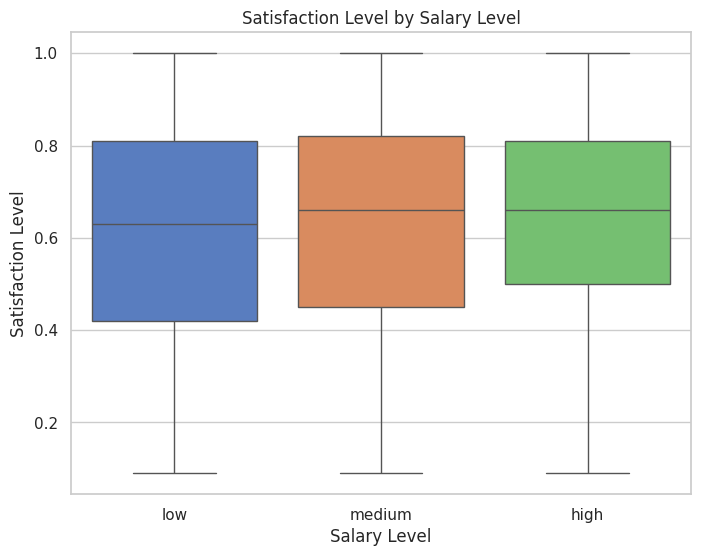

In [18]:

# Finally, we see if there is a relation between the salary and satisfaction level. One may think that a higher salary means a higher satisfaction level.
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='salary', y='satisfaction_level', palette='muted')
plt.title("Satisfaction Level by Salary Level")
plt.xlabel("Salary Level")
plt.ylabel("Satisfaction Level")
plt.show()

**Ensemble learning models**

**Individual models**
We will start the analysis with individual models, like Logistic Regression, Random Forest Classifier and SVC.

In [20]:
# To determine the satisfaction levels, we will consider that employees with satisfaction_level > 0.5 are 'satisfied' (1), and others as 'not satisfied' (0)
data['satisfied'] = (data['satisfaction_level'] > 0.5).astype(int)
# The target value will be the 'satisfied' variable, that varies between 0 and 1
y = data['satisfied']

# The features are the remaining columns, without the employee ID
X = data.drop(columns=['satisfaction_level', 'Emp ID', 'satisfied'])
# We drop NAN values
X = X.dropna()
y = y[X.index]
# One-hot encode categorical variables (creating binary columns for each categorical column)
X = pd.get_dummies(X, drop_first=True)

# We define training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=9)

# We select individual classifiers, in this case logistic regression, random forest classifier and SVC
log_clf = LogisticRegression(max_iter=1000, random_state=9)
rnd_clf = RandomForestClassifier(random_state=9)
svm_clf = SVC(random_state=9)

# Train and evaluate each model individually
print("Individual Classifier Performance:")

# Support Vector Classifier
svm_clf.fit(X_train, y_train)
svm_y_predict = svm_clf.predict(X_test)
print(f"SVM accuracy: {accuracy_score(y_test, svm_y_predict):.2f}")

# Logistic Regression Classifier
log_clf.fit(X_train, y_train)
log_y_predict = log_clf.predict(X_test)
print(f"Logistic Regression accuracy: {accuracy_score(y_test, log_y_predict):.2f}")

# Random Forest Classifier
rnd_clf.fit(X_train, y_train)
rnd_y_predict = rnd_clf.predict(X_test)
print(f"Random Forest accuracy: {accuracy_score(y_test, rnd_y_predict):.2f}")




Individual Classifier Performance:
SVM accuracy: 0.70
Logistic Regression accuracy: 0.68
Random Forest accuracy: 0.87


We can see that the Random Forest model achieved the highest accuracy of all the individual models. Let's now try to incorporate ensemble techniques to see if we can improve the accuracy.

**Ensemble model: Voting Classifier**


In [21]:
# We initialize the voting classifier ensemble model
voting_clf = VotingClassifier(
    estimators=[("lr", log_clf), ("rf", rnd_clf), ("svm", svm_clf)],
    voting="hard"
)
# We train and evaluate the Voting Classifier
print("\nVoting Classifier Performance:")
voting_clf.fit(X_train, y_train)
voting_y_predict = voting_clf.predict(X_test)
print(classification_report(y_test, voting_y_predict), "\n")


Voting Classifier Performance:
              precision    recall  f1-score   support

           0       0.80      0.20      0.31      1928
           1       0.72      0.98      0.83      4072

    accuracy                           0.73      6000
   macro avg       0.76      0.59      0.57      6000
weighted avg       0.75      0.73      0.66      6000
 



We can see that the voting ensemble model has a higher accuracy than the individual models SVC and Logistic Regression. However, the Random Forest model has the highest accuracy.

**Ensemble model: Decision Tree Classifiers**




In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.4,
                                                    random_state = 6)
# First we build a stump tree with a max depth of 1
stump_clf = DecisionTreeClassifier(max_depth=1, random_state=42)
stump_clf.fit(X_train, y_train)
stump_y_pred = stump_clf.predict(X_test)
print(f"Stump Classification Report")
print(classification_report(y_test, stump_y_pred), "\n")

# Then we build a deeper tree, with a max depth of 6
tree_clf = DecisionTreeClassifier(max_depth=6, random_state=42)
tree_clf.fit(X_train, y_train)
tree_y_pred = tree_clf.predict(X_test)
print(f"Tree Classification Report")
print(classification_report(y_test, tree_y_pred), "\n")

Stump Classification Report
              precision    recall  f1-score   support

           0       0.76      0.39      0.52      1926
           1       0.77      0.94      0.85      4074

    accuracy                           0.77      6000
   macro avg       0.77      0.67      0.68      6000
weighted avg       0.77      0.77      0.74      6000
 

Tree Classification Report
              precision    recall  f1-score   support

           0       0.88      0.61      0.72      1926
           1       0.84      0.96      0.90      4074

    accuracy                           0.85      6000
   macro avg       0.86      0.79      0.81      6000
weighted avg       0.85      0.85      0.84      6000
 



We can see that both models achieved very good accuracy levels, of 77% and 85% respectively. We see that increasing the depth helped to achieve a higher accuracy. However, the Random Forest model is the one that obtained the highest accuracy.